# 08. PyTorch Research Paper Replicating

Paper: [Transformer for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)

Anatomy of a research paper (general structure)
| **Section** | **What is it?** |
|-------------|-----------------|
| **Abstract** | An **overview/summary** of the paper's main findings/contributions. |
| **Introduction** | What's the paper's **main problem**? And details of previous methods used to try and solve it. |
| **Method** | What **steps did the researchers take** when conducting their research? For example, what model(s), data sources, training setups were used? |
| **Results** | What are the **outcomes** of the paper? If a new type of model or traning setup was used, how did the results of findings compare to previous works? (this is where experiment tracking comes in handy) |
| **Conclusion** | What are the **limitations** of the suggested methods? What are some next steps for the research community? |
| **References** | What **resources/other papers** did the researchers look at to build their own body of work? |
| **Appendix** | Are there any **extra resources/findings** to look at that weren't included in any of the above sections |

What will be covered in this module?
* Getting setup (importing previously written code)
* Introduce machine learning paper replicating with PyTorch
* Replicating Vision Transformer(ViT) for FoodVision Mini
* Training a custom ViT
* Feature extraction with a pretrained ViT

Goal: Turn an ML research paper into usable code.

In this notebook, we're going to replicating the ViT architecture/paper with PyTorch

## 0. Get setup

Let's import code we've previously written + required libraries

In [11]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    
# Try to import going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular module... downloading it.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

f:\Codes\pytorch-for-deep-learning-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


## 1. Get Data

The whole goal of what we're trying to do is to replicate the ViR architecture for FoodVision Mini problem

In [12]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [13]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [14]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [15]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Image size
IMAGE_SIZE = 224  # Comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

In [16]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for my smaller hardware)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [17]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

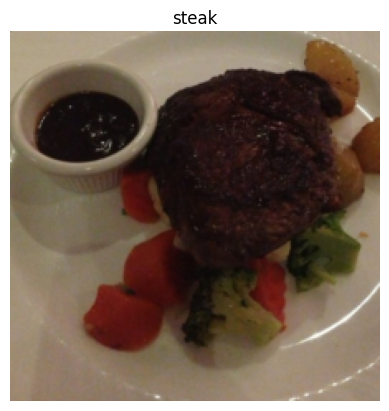

In [18]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

* **Input** - What goes into the model? (in the case, image tensors)
* **Output** - What comes out of the model/layer/block? (in the case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT Overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Table 1/3: different hyperparameters for the architecture/training.
* Four equations: math questions which define the functions of each layer/block

#### Figure 1

![Figure 1. ViT Model Overview](../assets/vit-figure-1-model-overview.png)

* Embedding: learnable representation (start with random numbers and improve over time)

#### ViT Overview: Inputs and Outputs

![ViT Overview: Inputs and Outputs](../assets/vit-overview-inputs-and-outputs.png)

#### Four equations

![Four equations](../assets/vit-four-equations.png)

#### Section 3.1 describes the various equations:

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_pathc_2_pos, ... image_patch_N_pos]
```

---

**Equation 1:**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

---

**Equation 2&3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

---

**Equation 4:**

Similar to BERT's \texttt{[class]} token, we prepend a learnable embedding to the sequence of embedded patches ($\mathbf{z}_0^0 = \mathbf{x}_{\text{class}}$), whose state at the output of the Transformer encoder ($\mathbf{z}_L^0$) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

---

#### ViT Overview: Four Equations

![ViT Overview: Four Equations](../assets/vit-overview-four-equations.png)


#### Table 1

![Table 1. Details of ViT model variants](../assets/vit-table-1-details-of-ViT-model-variants.png)

* ViT-Base, ViT-Large, and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

>
> **Equation 1:** An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
>

>
>**Equation 1:** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.
>

* Input image: $H\times{W}\times{C}$ (height x width x color channels)
* Output image: ${N \times (P^2 \cdot C)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / P^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [19]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [20]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, patch dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

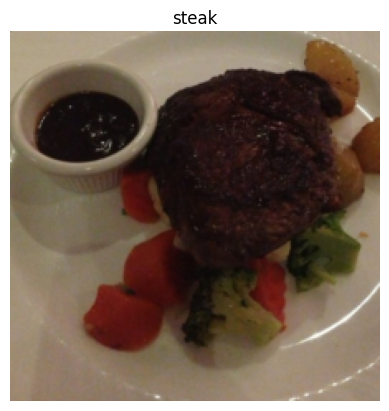

In [21]:
# View a single image
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [22]:
image.shape

torch.Size([3, 224, 224])

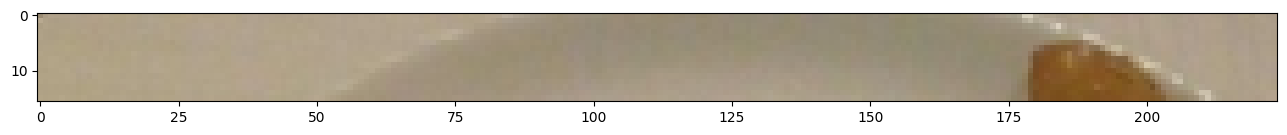

In [24]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # (C, H, W) -> (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


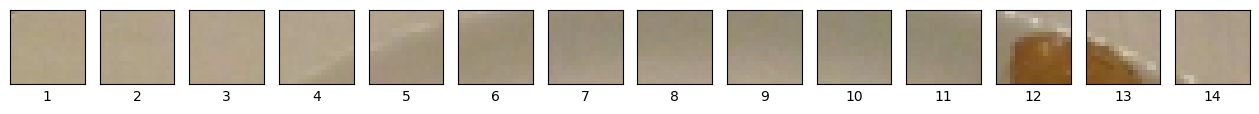

In [38]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches_per_row = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches_per_row}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through the number of patches per row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1) # set the patch label (1 -> 14)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [44]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches_per_row = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches_per_row}\
    \nNumber of patches per column: {num_patches_per_row}\
    \nTotal patches: {num_patches_per_row * num_patches_per_row}\
    \nPatch size: {patch_size} pixels x {patch_size} pixels")



print(image_permuted)
print(image_permuted.shape)

Number of patches per row: 14    
Number of patches per column: 14    
Total patches: 196    
Patch size: 16 pixels x 16 pixels
tensor([[[0.6078, 0.5490, 0.4549],
         [0.6745, 0.6157, 0.5255],
         [0.6941, 0.6353, 0.5451],
         ...,
         [0.6784, 0.6196, 0.5373],
         [0.6667, 0.6078, 0.5333],
         [0.6667, 0.6078, 0.5333]],

        [[0.7216, 0.6627, 0.5647],
         [0.6863, 0.6314, 0.5333],
         [0.6784, 0.6196, 0.5255],
         ...,
         [0.6824, 0.6235, 0.5412],
         [0.6745, 0.6157, 0.5373],
         [0.6667, 0.6078, 0.5333]],

        [[0.6745, 0.6196, 0.5176],
         [0.6902, 0.6353, 0.5333],
         [0.6824, 0.6275, 0.5255],
         ...,
         [0.6706, 0.6118, 0.5294],
         [0.6745, 0.6157, 0.5412],
         [0.6745, 0.6157, 0.5412]],

        ...,

        [[0.6196, 0.5294, 0.4549],
         [0.6157, 0.5333, 0.4510],
         [0.6039, 0.5216, 0.4353],
         ...,
         [0.6039, 0.5373, 0.4667],
         [0.6039, 0.5373, 

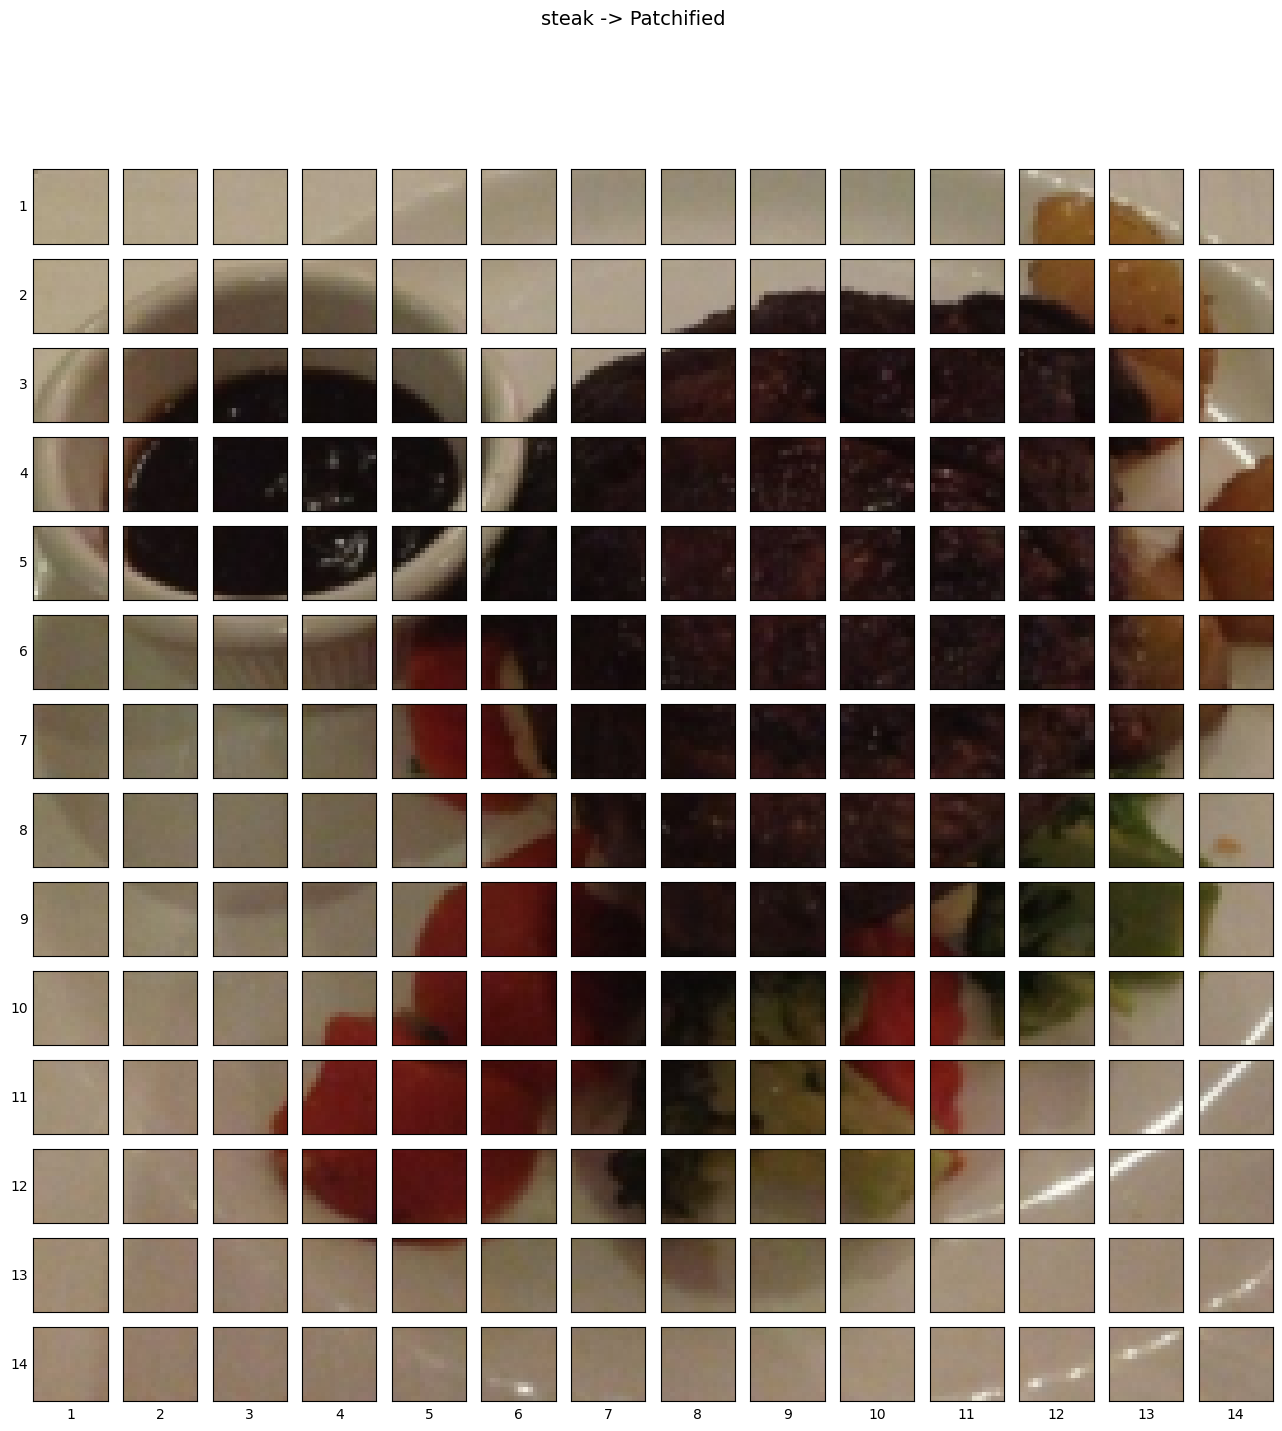

In [47]:
# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # one row for each patch
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information for each subplot
        axs[i, j].set_ylabel(i + 1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patche and turning them into patch embeddings

Create the image patches and image patch embedding in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`

In [49]:
# Create Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D = embedding dimension -> from Table 1
                   kernel_size=patch_size, # size of the patch 
                   stride=patch_size, # non-overlapping patches
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

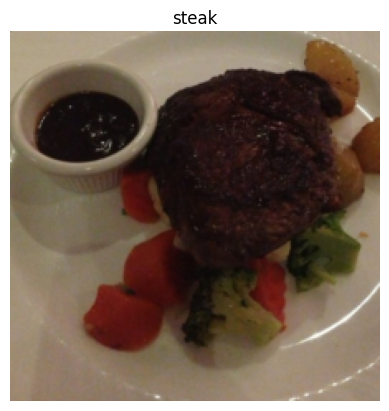

In [50]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [52]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)

torch.Size([1, 768, 14, 14])


In [53]:
#now we've passed a single image t the `conv2d` layer, it's shape is
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [462, 445, 312, 237, 646]


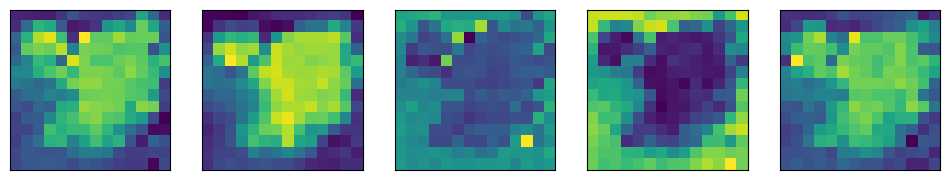

In [54]:
# plot random convolutional feature maps (embeddings)
import random
random_indexs = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexs}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexs):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [55]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.4872,  0.4898,  0.4852,  0.4784,  0.4207,  0.4351,  0.4677,
            0.4671,  0.4669,  0.4428,  0.4329,  0.2726,  0.4526,  0.4979],
          [ 0.4884,  0.2108,  0.2064,  0.2507,  0.3635,  0.4836,  0.4813,
            0.3295, -0.0146,  0.1150,  0.0225,  0.0869,  0.2097,  0.4017],
          [ 0.3089,  0.0824,  0.0379,  0.0339,  0.1516,  0.3420,  0.0115,
            0.0627,  0.0359,  0.0410,  0.0571,  0.0574,  0.1455,  0.4908],
          [ 0.2822,  0.0211,  0.0476,  0.0669,  0.1695,  0.0201,  0.0465,
            0.0664,  0.0859,  0.0785,  0.0498,  0.0771,  0.4115,  0.0856],
          [ 0.3124,  0.2967,  0.0853,  0.2778,  0.2403,  0.0103,  0.0494,
            0.0704,  0.1069,  0.0270,  0.0517,  0.0542,  0.1798,  0.1565],
          [ 0.2724,  0.2868,  0.2426,  0.1712,  0.0870,  0.1017,  0.0321,
            0.0735,  0.0699,  0.0265,  0.0609,  0.0705,  0.1637,  0.3017],
          [ 0.3004,  0.3405,  0.3097,  0.2668,  0.0634,  0.1088,  0.0377,
            0.0550,  0.0752,  0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [57]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [59]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).permute(0, 2, 1).shape

torch.Size([1, 196, 768])

Original image shape: torch.Size([3, 224, 224]) -> (color_channels, height, width)
Image feature map after conv2d layer: torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)
Image patch embeddings after flattening: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


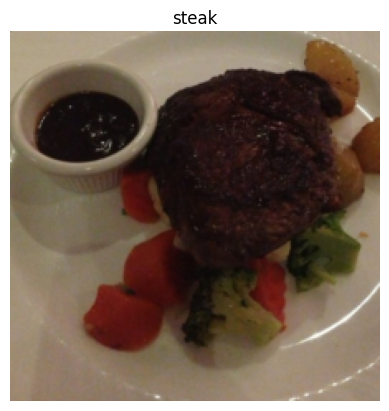

In [61]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape} -> (color_channels, height, width)")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(f"Image feature map after conv2d layer: {image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

# Flatten the feature maps into a sequence of patch embeddings
image_out_of_conv_flatten = flatten_layer(image_out_of_conv).permute(0, 2, 1) # (batch_size, number_of_patches, embedding_dim)
print(f"Image patch embeddings after flattening: {image_out_of_conv_flatten.shape} -> (batch_size, number_of_patches, embedding_dim)")

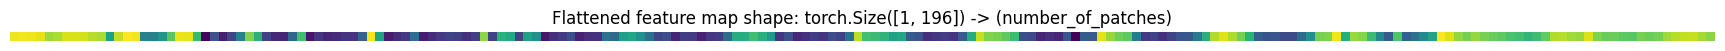

In [63]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flatten[:, :, 0]
single_flattened_feature_map

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape} -> (number_of_patches)")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [71]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with appropriate hyperparameters
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768): # From Table 1 for ViT-Base
        super().__init__()
        
        self.patch_size = patch_size
    
        # 3. Create a layer to turn an image into embedding patches using nn.Conv2
        self.patcher = nn.Conv2d(in_channels=in_channels, # 3
                                 out_channels=embedding_dim, # 768
                                 kernel_size=patch_size, # 16
                                 stride=patch_size, # 16
                                 padding=0)
        # 4. Create a layer to flatten the feature maps of the output of the layer in 3
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # 5. Define a forward() that defines the forward computation steps
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1] # get the height/width of the image
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by the patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patch = self.patcher(x) # (batch_size, embedding_dim, feature_map_height, feature_map_width)
        x_flattened = self.flatten(x_patch).permute(0, 2, 1) # (batch_size, number_of_patches, embedding_dim)
        return x_flattened
    

In [72]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through the patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape} -> (batch_size, number_of_patches, embedding_dim)")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


In [74]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250) # AssertionError: Input image size must be divisible by the patch size, image shape: 250, patch size: 16

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class to token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [78]:
patch_embedded_image

tensor([[[-0.6797,  0.1554, -0.1819,  ...,  0.4847, -0.3026,  0.2465],
         [-0.6795,  0.1606, -0.1837,  ...,  0.4893, -0.3213,  0.2541],
         [-0.6827,  0.1559, -0.1790,  ...,  0.4957, -0.3202,  0.2448],
         ...,
         [-0.6023,  0.0895, -0.1864,  ...,  0.3998, -0.2273,  0.1965],
         [-0.6654,  0.1488, -0.1509,  ...,  0.4516, -0.2958,  0.2608],
         [-0.5926,  0.1257, -0.1414,  ...,  0.4151, -0.2769,  0.1981]]],
       grad_fn=<PermuteBackward0>)

In [80]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [84]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [87]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6797,  0.1554, -0.1819,  ...,  0.4847, -0.3026,  0.2465],
         [-0.6795,  0.1606, -0.1837,  ...,  0.4893, -0.3213,  0.2541],
         ...,
         [-0.6023,  0.0895, -0.1864,  ...,  0.3998, -0.2273,  0.1965],
         [-0.6654,  0.1488, -0.1509,  ...,  0.4516, -0.2958,  0.2608],
         [-0.5926,  0.1257, -0.1414,  ...,  0.4151, -0.2769,  0.1981]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [88]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6797,  0.1554, -0.1819,  ...,  0.4847, -0.3026,  0.2465],
          [-0.6795,  0.1606, -0.1837,  ...,  0.4893, -0.3213,  0.2541],
          ...,
          [-0.6023,  0.0895, -0.1864,  ...,  0.3998, -0.2273,  0.1965],
          [-0.6654,  0.1488, -0.1509,  ...,  0.4516, -0.2958,  0.2608],
          [-0.5926,  0.1257, -0.1414,  ...,  0.4151, -0.2769,  0.1981]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [91]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
print(f"Number of patches: {number_of_patches}, Embedding dimension: {embedding_dimension}")

# Create the learnable 1D position embeddings
position_embeddings = nn.Parameter(torch.ones(1,
                                              number_of_patches + 1, # +1 for class token
                                              embedding_dimension))
position_embeddings, position_embeddings.shape

Number of patches: 196, Embedding dimension: 768


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [93]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6797,  0.1554, -0.1819,  ...,  0.4847, -0.3026,  0.2465],
          [-0.6795,  0.1606, -0.1837,  ...,  0.4893, -0.3213,  0.2541],
          ...,
          [-0.6023,  0.0895, -0.1864,  ...,  0.3998, -0.2273,  0.1965],
          [-0.6654,  0.1488, -0.1509,  ...,  0.4516, -0.2958,  0.2608],
          [-0.5926,  0.1257, -0.1414,  ...,  0.4151, -0.2769,  0.1981]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [94]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embeddings
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3203, 1.1554, 0.8181,  ..., 1.4847, 0.6974, 1.2465],
         [0.3205, 1.1606, 0.8163,  ..., 1.4893, 0.6787, 1.2541],
         ...,
         [0.3977, 1.0895, 0.8136,  ..., 1.3998, 0.7727, 1.1965],
         [0.3346, 1.1488, 0.8491,  ..., 1.4516, 0.7042, 1.2608],
         [0.4074, 1.1257, 0.8586,  ..., 1.4151, 0.7231, 1.1981]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings

Now let's do it all in one cell

In [107]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapé of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape} -> (batch_size, number_of_patches, embedding_dim)")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token shape: {class_token.shape} -> (batch_size, 1, embedding_dim)")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                              number_of_patches + 1, # +1 for class token
                                              embedding_dimension), requires_grad=True)

# 9. Add the position embedding to the patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)
Class token shape: torch.Size([1, 1, 768]) -> (batch_size, 1, embedding_dim)
Patch embedding with class token shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)
Patch and position embedding shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + 1, embedding_dim)


## 5. Equation 2: Multihead Self-Attention (MSA Block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?

> * In the case, we have a series of embedded image patches, which patch significantly relates to another patch.
> We want the neural network (ViT) to learn this relationship/representation
* To replicate MSA in PyTorch we can use: https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 
* Layer Norm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy
> * Normalization = make everything have the same mean and same standard deviation
> * In PyTorch = https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in the case, the $D$ dimension is the embedding dimension.
>   * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size

In [110]:
class MutliHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""
    def __init__(self,
                 embedding_dimension: int = 768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
                 num_heads: int = 12, # Heads from Table 1 for ViT-Base
                 attn_dropout: int = 0):
        super().__init__()
        # Create a norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        # Create a multihead attention layer (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # batch_first=True -> (batch_size, sequence_length, feature) -> (batch_size, number_of_patches, embedding_dimension)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. Pass the input through the norm layer
        x_norm = self.layer_norm(x)
        # 2. Pass the normalized input through the multi-head attention layer
        attn_output, _ = self.multihead_attn(query=x_norm,
                                             key=x_norm,
                                             value=x_norm,
                                             need_weights=False) # we don't need the attention weights for ViT
        return attn_output

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MutliHeadSelfAttentionBlock(
    embedding_dimension=768, num_heads=12, attn_dropout=0
)

# Pass the patch and position embedding sequence through the MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape} -> (batch_size, number_of_patches + 1, embedding_dim)")

tensor([[[ 0.3760, -0.0790,  0.6969,  ...,  0.0856,  0.5478,  0.1634],
         [ 0.3634, -0.0757,  0.6993,  ...,  0.0806,  0.5443,  0.1674],
         [ 0.3636, -0.0758,  0.6989,  ...,  0.0804,  0.5442,  0.1675],
         ...,
         [ 0.3634, -0.0752,  0.6993,  ...,  0.0805,  0.5437,  0.1663],
         [ 0.3641, -0.0751,  0.6995,  ...,  0.0808,  0.5453,  0.1673],
         [ 0.3635, -0.0754,  0.6988,  ...,  0.0805,  0.5438,  0.1675]]],
       grad_fn=<TransposeBackward0>)